In [1]:
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF, CountVectorizer, Normalizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, DoubleType, StringType, StructType, StructField
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
from nltk.sentiment import SentimentIntensityAnalyzer
from pyspark.ml import Pipeline, PipelineModel
import pyspark

# Data Retrieval

In [2]:
data_file = r"/home/jovyan/repos/distributed-sentiment-analysis-on-twitter-data/twitter_data_en/*.csv"
vader_analyzer = SentimentIntensityAnalyzer()

In [3]:
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '10g'),
                                   ('spark.driver.memory','10g'),
                                   ('spark.master', 'local[*]')])

# Initialize a Spark session
spark = SparkSession \
    .builder \
    .appName("SentimentAnalysis") \
    .config(conf=conf) \
    .getOrCreate()

sc = spark.sparkContext

In [4]:
sc.getConf().getAll()

[('spark.app.id', 'local-1524588696113'),
 ('spark.driver.host', 'de4f1c03e850'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.port', '42805'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '10g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'SentimentAnalysis'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
# define the data schema(format/structure) for our twitter data in the csv file
twitter_data_schema = StructType([StructField("date_str", StringType(), True),
                                  StructField("tweet_id", StringType(), True),
                                  StructField("text", StringType(), True),
                                  StructField("location", StringType(), True),
                                  StructField("user_id", StringType(), True),
                                  StructField("user_name", StringType(), True),
                                  StructField("user_location", StringType(), True),
                                  StructField("user_url", StringType(), True),
                                  StructField("user_description", StringType(), True),
                                  StructField("place_id", StringType(), True),
                                  StructField("place_url", StringType(), True),
                                  StructField("place_type", StringType(), True),
                                  StructField("place_countrycode", StringType(), True),
                                  StructField("place_country", StringType(), True),
                                  StructField("place_boundingboxtype", StringType(), True),
                                  StructField("entities_hashtags", StringType(), True),
                                  StructField("entities_urls", StringType(), True),
                                  StructField("entities_mentions", StringType(), True),
                                  StructField("entities_symbols", StringType(), True),
                                  StructField("entities_media", StringType(), True),
                                  StructField("entities_polls", StringType(), True),])

In [6]:
df_raw = spark.read.csv(
    data_file, schema=twitter_data_schema
)

In [7]:
text_and_loc_only = df_raw.select("text", "location")

In [8]:
text_and_loc_only.cache()

text_and_loc_only.count()

4135439

# Tweet Cleaning Function

In [9]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

at_user_pat = r'@[A-Za-z0-9_]+'  # r'@[\w]+'
url_pat = r'https?://[^ ]+'  # r'https?:\/\/[^\s]+'
www_pat = r'www.[^ ]+'
repeating_chars_pat = r'([A-Za-z])\1+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(at_user_pat, 'USERNAME', bom_removed)
    stripped = re.sub(url_pat, 'URL', stripped)
    stripped = re.sub(www_pat, 'URL', stripped)
    stripped = re.sub(repeating_chars_pat, r'\1\1', stripped)

    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

# Data Pre-Processing

In [10]:
df_filtered = text_and_loc_only.filter("location like '%,___'")
df_filtered.show(truncate=True)

+--------------------+-----------------+
|                text|         location|
+--------------------+-----------------+
|USER_NAME dammit ...|Mountain View, CA|
|Seriously Olivia ...|    Manhattan, NY|
|Thank you to the ...|       Austin, TX|
|Lmao ay fuck you URL|      Atlanta, GA|
|You and Zariah ar...|      Clinton, MI|
|The tears are com...|       Porter, TX|
|I always get my h...|   Statesboro, GA|
|USER_NAME 2014 FH...|  New Orleans, LA|
|USER_NAME Looking...|  Los Angeles, CA|
|I'm at The Dudes'...|     Torrance, CA|
|Now I need Brewho...|    Nashville, TN|
|This looks like a...|    Manhattan, NY|
|USER_NAME Num sit...|  Haddonfield, NJ|
|Looking forward t...|    Montclair, NJ|
|degrees are worth...|     Waterloo, IA|
|USER_NAME USER_NA...|        Alvin, TX|
|I’m starting not ...|        Davie, FL|
|       I’m exhausted|       Albany, OR|
|Saw this at USER_...|     Brooklyn, NY|
|USER_NAME Not ton...|   California, PA|
+--------------------+-----------------+
only showing top

In [11]:
df_filtered.count()

2572005

In [12]:
udf_tweet_cleaner = udf(tweet_cleaner)
df_preprocessed = df_filtered.withColumn("text", udf_tweet_cleaner(col("text")))
df_preprocessed.show(truncate=True)

+--------------------+-----------------+
|                text|         location|
+--------------------+-----------------+
|user name dammit ...|Mountain View, CA|
|seriously olivia ...|    Manhattan, NY|
|thank you to the ...|       Austin, TX|
|lmao ay fuck you url|      Atlanta, GA|
|you and zariah ar...|      Clinton, MI|
|the tears are com...|       Porter, TX|
|always get my hop...|   Statesboro, GA|
|user name fhd is ...|  New Orleans, LA|
|user name looking...|  Los Angeles, CA|
|at the dudes brew...|     Torrance, CA|
|now need brewhous...|    Nashville, TN|
|this looks like t...|    Manhattan, NY|
|user name num sit...|  Haddonfield, NJ|
|looking forward t...|    Montclair, NJ|
|degrees are worth...|     Waterloo, IA|
|user name user na...|        Alvin, TX|
|starting not to c...|        Davie, FL|
|           exhausted|       Albany, OR|
|saw this at user ...|     Brooklyn, NY|
|user name not ton...|   California, PA|
+--------------------+-----------------+
only showing top

In [13]:
df_preprocessed.cache()

df_preprocessed.count()

2572005

In [14]:
def count(text):
    return 1

udf_count = udf(count)

In [15]:
MIN_TWEETS_COUNT = 1000

# Ranking Result of NLTK Analyzer 

In [16]:
def nltk_prediction(text):
    result = vader_analyzer.polarity_scores(str(text))
    prediction = 1 if result['compound'] >= 0 else 0

    return prediction

udf_nltk_prediction = udf(nltk_prediction)

In [17]:
def nltk_score(text):
    result = vader_analyzer.polarity_scores(str(text))
    prediction = result['compound']

    return prediction

udf_nltk_score = udf(nltk_score)

In [18]:
df_scored = df_preprocessed.withColumn("prediction", udf_nltk_prediction(col("text")))
df_scored = df_scored.withColumn("score", udf_nltk_score(col("text")))
df_scored = df_scored.withColumn("count", udf_count(col("text")))

df_scored.cache()
df_scored.count()

3824630

In [19]:
# Ranking by averaging 1/0 values
df_scored.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|   avg(prediction)|sum(count)|
+--------------------+------------------+----------+
|    Cedar Rapids, IA| 0.860813704496788|    2335.0|
|    Myrtle Beach, SC| 0.842344906089926|    1757.0|
|        Carlsbad, CA|0.8408501814411612|    1929.0|
|       Asheville, NC|0.8335759340126152|    2061.0|
|       Allentown, PA|0.8313953488372093|    1548.0|
|        Portland, ME|0.8277046365197481|    1747.0|
|         Roanoke, VA|0.8262792166771952|    1583.0|
|        Hartford, CT|0.8179129700042248|    2367.0|
|   Overland Park, KS|0.8171314741035857|    2510.0|
|      Greenville, SC|0.8167449807774455|    2341.0|
|     Miami Beach, FL|0.8146392838335966|    3798.0|
|        New York, NY|0.8141097424412094|    1786.0|
|       Lynchburg, VA|0.8109484404837684|    1571.0|
|       Manhattan, KS|0.8098318240620958|    1546.0|
|   Bowling Green, KY| 0.808106942647693|    2319.0|
|         Lincoln, NE| 0.807402625349688|    4

In [20]:
# Ranking by averaging compound scores
df_scored.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+--------------------+----------+
|            location|          avg(score)|sum(count)|
+--------------------+--------------------+----------+
|    Myrtle Beach, SC| 0.23468577120091066|    1757.0|
|         Fremont, CA| 0.23202358235823584|    2222.0|
|        Carlsbad, CA| 0.21929756350440643|    1929.0|
|    Cedar Rapids, IA|  0.2135770449678801|    2335.0|
|         Livonia, MI| 0.20285403645833336|    1536.0|
|       Asheville, NC| 0.20231135371179043|    2061.0|
|        New York, NY|  0.1994396976483763|    1786.0|
|        Portland, ME| 0.19595540927303948|    1747.0|
|   Overland Park, KS| 0.19472609561752988|    2510.0|
|           Plano, TX| 0.19202989464442494|    4556.0|
|          Frisco, TX| 0.19165431846090875|    2443.0|
|         Roanoke, VA|  0.1910740366392925|    1583.0|
|           Omaha, NE| 0.19100866381940193|    8195.0|
|   Bowling Green, KY| 0.18804557999137564|    2319.0|
|          Conway, AR| 0.18544878197320344|    1642.0|
|      San

# Ranking Result of Logistic Regression

In [16]:
def extract_probability(input):
    return input.toArray().tolist()[1]

udf_extract_probability = udf(extract_probability)

In [17]:
trigramwocs_pipelineFit_loaded = PipelineModel.load("ngram_cv_idf_lr")

In [18]:
%%time
df_ngram_cv_idf_lr = trigramwocs_pipelineFit_loaded.transform(df_preprocessed)

df_ngram_cv_idf_lr = df_ngram_cv_idf_lr.withColumn("count", udf_count(col("text")))
df_ngram_cv_idf_lr = df_ngram_cv_idf_lr.withColumn("score", udf_extract_probability(df_ngram_cv_idf_lr.probability))

# df_ngram_cv_idf_lr.cache()
# df_ngram_cv_idf_lr.count()

CPU times: user 80 ms, sys: 20 ms, total: 100 ms
Wall time: 1.07 s


In [19]:
%%time
# Ranking by averaging 1/0 values
df_ngram_cv_idf_lr.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|   avg(prediction)|sum(count)|
+--------------------+------------------+----------+
|       Allentown, PA|0.8324561403508772|    1140.0|
|  West Hollywood, CA| 0.807710171853228|    2153.0|
|            Cary, NC|0.7998324958123953|    1194.0|
|        Portland, ME|0.7993553585817889|    1241.0|
|        New York, NY|0.7965665236051502|    1165.0|
|    Myrtle Beach, SC|0.7926229508196722|    1220.0|
|   Beverly Hills, CA|0.7919637070641607|    1543.0|
|    Santa Monica, CA|0.7890849405006155|    2437.0|
|           Plano, TX| 0.780549415850963|    3167.0|
|        Carlsbad, CA| 0.780380673499268|    1366.0|
|   Santa Barbara, CA|0.7799126637554585|    1145.0|
|       Manhattan, NY| 0.779058464102208|   57608.0|
|      Naperville, IL|0.7789084181313598|    1081.0|
|         Boulder, CO|0.7778457772337821|    1634.0|
|        Bellevue, WA|0.7766423357664234|    1370.0|
|          Topeka, KS|0.7761332099907493|    1

In [20]:
%%time
# Ranking by averaging probabilities
df_ngram_cv_idf_lr.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|        avg(score)|sum(count)|
+--------------------+------------------+----------+
|        New York, NY|  0.70666778533216|    1165.0|
|  West Hollywood, CA|0.7040041453827921|    2153.0|
|    Myrtle Beach, SC|0.7037779028379595|    1220.0|
|        Portland, ME|0.6952667801751606|    1241.0|
|            Cary, NC|0.6912494010587222|    1194.0|
|    Santa Monica, CA|0.6896842628904362|    2437.0|
|   Beverly Hills, CA|0.6886448425456099|    1543.0|
|         Fremont, CA|0.6879068260478328|    1477.0|
|        Franklin, TN|0.6859634840230158|    1224.0|
|           Plano, TX|0.6850551497989416|    3167.0|
|      Naperville, IL|0.6839277247818855|    1081.0|
|        Carlsbad, CA|0.6836865502108296|    1366.0|
|        Stamford, CT|0.6829821011086784|    1350.0|
|         Fishers, IN|0.6808527266078457|    1005.0|
|          Topeka, KS|0.6806032360112236|    1081.0|
|     Miami Beach, FL|0.6801778738883958|    2

# Ranking Result of Naive Bayes

In [21]:
nb_pipelineFit_loaded = PipelineModel.load("ngram_cv_idf_nb")

In [22]:
%%time
df_ngram_cv_idf_nb = nb_pipelineFit_loaded.transform(df_preprocessed)

df_ngram_cv_idf_nb = df_ngram_cv_idf_nb.withColumn("count", udf_count(col("text")))
df_ngram_cv_idf_nb = df_ngram_cv_idf_nb.withColumn("score", udf_extract_probability(df_ngram_cv_idf_nb.probability))

# df_ngram_cv_idf_nb.cache()
# df_ngram_cv_idf_nb.count()

CPU times: user 50 ms, sys: 10 ms, total: 60 ms
Wall time: 455 ms


In [23]:
%%time
# Ranking by averaging 1/0 values
df_ngram_cv_idf_nb.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|   avg(prediction)|sum(count)|
+--------------------+------------------+----------+
|       Allentown, PA|0.7947368421052632|    1140.0|
|  West Hollywood, CA|0.7807710171853228|    2153.0|
|        Portland, ME|0.7751813053988719|    1241.0|
|   Santa Barbara, CA|0.7685589519650655|    1145.0|
|        New York, NY|0.7639484978540773|    1165.0|
|    Myrtle Beach, SC|0.7598360655737705|    1220.0|
|            Cary, NC|0.7579564489112228|    1194.0|
|   Beverly Hills, CA|0.7569669475048607|    1543.0|
|        Carlsbad, CA|0.7554904831625183|    1366.0|
|      Naperville, IL|0.7539315448658649|    1081.0|
|        Franklin, TN|0.7524509803921569|    1224.0|
|    Santa Monica, CA|0.7505129257283545|    2437.0|
|        Stamford, CT|0.7437037037037038|    1350.0|
|       Cambridge, MA|0.7435897435897436|    2145.0|
|     Springfield, IL|0.7429679922405431|    1031.0|
|         Seattle, WA|0.7427543896763275|   14

In [24]:
%%time
# Ranking by averaging probabilities
df_ngram_cv_idf_nb.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|        avg(score)|sum(count)|
+--------------------+------------------+----------+
|       Allentown, PA|0.7777828726979412|    1140.0|
|  West Hollywood, CA|0.7758482407258648|    2153.0|
|        Portland, ME|0.7730097349103705|    1241.0|
|   Santa Barbara, CA|0.7655146912649099|    1145.0|
|        New York, NY|0.7640857685450134|    1165.0|
|    Myrtle Beach, SC|0.7579769398161689|    1220.0|
|            Cary, NC|0.7565062566316744|    1194.0|
|   Beverly Hills, CA|0.7554896500543025|    1543.0|
|        Carlsbad, CA|0.7531958378334119|    1366.0|
|      Naperville, IL|0.7529331146113688|    1081.0|
|    Santa Monica, CA|0.7505431022016315|    2437.0|
|        Franklin, TN|0.7498323811501847|    1224.0|
|        Stamford, CT|0.7435396767451395|    1350.0|
|       Cambridge, MA|0.7418543741056924|    2145.0|
|         Seattle, WA|0.7392496301486151|   14181.0|
|          Topeka, KS|0.7391334636092858|    1

# Ranking Result of Gradient Boost Tree

In [29]:
gbt_pipelineFit_loaded = PipelineModel.load("ngram_cv_idf_gbt")

In [30]:
%%time
df_ngram_cv_idf_gbt = gbt_pipelineFit_loaded.transform(df_preprocessed)

df_ngram_cv_idf_gbt = df_ngram_cv_idf_gbt.withColumn("count", udf_count(col("text")))
df_ngram_cv_idf_gbt = df_ngram_cv_idf_gbt.withColumn("score", udf_extract_probability(df_ngram_cv_idf_gbt.probability))

# df_ngram_cv_idf_gbt.cache()
# df_ngram_cv_idf_gbt.count()

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 1min 28s


In [50]:
# Ranking by averaging 1/0 values
df_ngram_cv_idf_gbt.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+-------------------+----------+
|            location|    avg(prediction)|sum(count)|
+--------------------+-------------------+----------+
|           Miami, FL| 0.5641025641025641|    3588.0|
|       Manhattan, NY| 0.5255362165963432|   22752.0|
|       Arlington, VA| 0.5033639143730887|    1635.0|
|         Orlando, FL| 0.5024390243902439|    2665.0|
|        Paradise, NV| 0.4970913321698662|    3438.0|
|      Washington, DC| 0.4951217288228321|   10967.0|
|         Memphis, TN| 0.4937425506555423|    3356.0|
|     Kansas City, MO|0.49344188150158297|    2211.0|
|      Louisville, KY| 0.4924165824064712|    1978.0|
|   Oklahoma City, OK|0.48501997336884156|    3004.0|
|        St Louis, MO|  0.484352773826458|    1406.0|
|        Richmond, VA| 0.4833916083916084|    2288.0|
|          Newark, NJ|0.48328488372093026|    1376.0|
|      Providence, RI| 0.4829443447037702|    1114.0|
|         Raleigh, NC| 0.4822081809112072|    3007.0|
|   Winston-Salem, NC|0.4812

In [51]:
# Ranking by averaging probabilities
df_ngram_cv_idf_gbt.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+-------------------+----------+
|            location|         avg(score)|sum(count)|
+--------------------+-------------------+----------+
|           Miami, FL| 0.5012493508181272|    3588.0|
|       Knoxville, TN| 0.4976333926016323|    1788.0|
|         Wichita, KS| 0.4958093351229608|    1463.0|
|       Manhattan, NY|0.49526398279755673|   22752.0|
|         Raleigh, NC| 0.4939748036563767|    3007.0|
|         Memphis, TN| 0.4937799938588579|    3356.0|
|           Omaha, NE| 0.4937207780029819|    1947.0|
|        Paradise, NV| 0.4933984089190469|    3438.0|
|         Buffalo, NY| 0.4923418791605366|    1791.0|
|        Richmond, VA| 0.4923020475342615|    2288.0|
|           Plano, TX|0.49227573842741384|    1258.0|
|      Louisville, KY|0.49181196757278706|    1978.0|
|     Minneapolis, MN| 0.4914916397452657|    2864.0|
|     Kansas City, MO|0.49130222148605934|    2211.0|
|       Arlington, VA| 0.4912890865157912|    1635.0|
|         Orlando, FL| 0.491

# Ranking Result of Linear SVM

In [25]:
lsvc_pipelineFit_loaded = PipelineModel.load("ngram_cv_idf_lsvc")

In [26]:
%%time
df_ngram_cv_idf_lsvc = lsvc_pipelineFit_loaded.transform(df_preprocessed)

df_ngram_cv_idf_lsvc = df_ngram_cv_idf_lsvc.withColumn("count", udf_count(col("text")))
df_ngram_cv_idf_lsvc = df_ngram_cv_idf_lsvc.withColumn("score", udf_extract_probability(df_ngram_cv_idf_lsvc.rawPrediction))

# df_ngram_cv_idf_lsvc.cache()
# df_ngram_cv_idf_lsvc.count()

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 758 ms


In [27]:
%%time
# Ranking by averaging 1/0 values
df_ngram_cv_idf_lsvc.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False).show(n=1000)

+--------------------+------------------+----------+
|            location|   avg(prediction)|sum(count)|
+--------------------+------------------+----------+
|       Allentown, PA|0.8289473684210527|    1140.0|
|  West Hollywood, CA|0.8058522991175104|    2153.0|
|        New York, NY|0.8017167381974248|    1165.0|
|        Portland, ME|0.8009669621273167|    1241.0|
|            Cary, NC|0.7981574539363484|    1194.0|
|   Beverly Hills, CA|0.7900194426441997|    1543.0|
|    Myrtle Beach, SC|0.7860655737704918|    1220.0|
|    Santa Monica, CA|0.7858022158391464|    2437.0|
|        Stamford, CT|0.7785185185185185|    1350.0|
|   Santa Barbara, CA|0.7781659388646288|    1145.0|
|         Fishers, IN|0.7781094527363184|    1005.0|
|       Manhattan, NY| 0.777287876683794|   57608.0|
|        Bellevue, WA| 0.775912408759124|    1370.0|
|          Topeka, KS|0.7752081406105458|    1081.0|
|      Naperville, IL|0.7752081406105458|    1081.0|
|        Franklin, TN|0.7745098039215687|    1

In [28]:
%%time
# Ranking by averaging raw predictions
df_ngram_cv_idf_lsvc.groupBy('location').agg({'score': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(score)', ascending=False).show(n=1000)

+--------------------+--------------------+----------+
|            location|          avg(score)|sum(count)|
+--------------------+--------------------+----------+
|       Arlington, VA|  1.2112141411439694|    4236.0|
|        Stamford, CT|   1.097610491809791|    1350.0|
|    Myrtle Beach, SC|  1.0484378169822104|    1220.0|
|         Fremont, CA|  0.9704644266675192|    1477.0|
|        New York, NY|  0.8818580792695596|    1165.0|
|           Plano, TX|  0.8303336532492278|    3167.0|
|        Portland, ME|  0.8126609475287407|    1241.0|
|       Roseville, CA|  0.7862801289728466|    1296.0|
|  West Hollywood, CA|  0.7611392409249708|    2153.0|
|    Coral Gables, FL|   0.760524604703192|    1083.0|
|      Santa Rosa, CA|  0.7582091351470532|    1043.0|
|         Spokane, WA|   0.754497056810877|    1851.0|
|        Franklin, TN|   0.717064265496275|    1224.0|
|    Santa Monica, CA|  0.7029175242336833|    2437.0|
|   Beverly Hills, CA|  0.6947320591373224|    1543.0|
|   St Pet

# Visualize Result on Map

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim, GoogleV3, Bing, GeocoderDotUS, GeoNames
import math

%matplotlib inline

In [47]:
df_result_lr = df_ngram_cv_idf_lr.groupBy('location').agg({'prediction': 'avg', 'count': 'sum'}).filter(col('sum(count)') > MIN_TWEETS_COUNT).sort('avg(prediction)', ascending=False)

In [49]:
df_result_lr.show(5)

+------------------+------------------+----------+
|          location|   avg(prediction)|sum(count)|
+------------------+------------------+----------+
|West Hollywood, CA|0.8111888111888111|     858.0|
|      Bellevue, WA|0.8035714285714286|     616.0|
|       Boulder, CO|0.7926267281105991|     651.0|
|  Santa Monica, CA|0.7876984126984127|    1008.0|
|   Miami Beach, FL| 0.786144578313253|     996.0|
+------------------+------------------+----------+
only showing top 5 rows



In [74]:
cities = []
for row in df_result_lr.collect():
    cities.append([row.location, float(row['avg(prediction)'])])

Franklin, TN


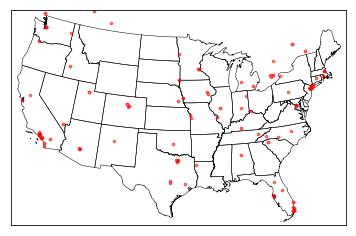

In [78]:
scale = 5

map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('./st99_d00', name='states', drawbounds=True)

# Get the location of each city and plot it
geolocator = Nominatim()
for (city, score) in cities[:100]:
    try:
        loc = geolocator.geocode(city)
    except:
        print("Except happened in geocoding {}".format(city))
        continue
    if loc is None:
        print(city)
        continue
    x, y = map(loc.longitude, loc.latitude)
    map.plot(x,y,marker='o',color='Red',markersize=score**2*scale,alpha=score**2)
plt.show()

# Tracking Frequent Terms

In [113]:
from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

#### Count for A Tourist City

In [119]:
# Change location to get other results
df_west_hollywood = df_preprocessed.filter(df_preprocessed.location == "West Hollywood, CA")

In [120]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
swremover = StopWordsRemover(inputCol="words", outputCol="words_after_removal")
track_freq_pipeline = Pipeline(stages=[tokenizer, swremover])

track_freq_pipeline_model = track_freq_pipeline.fit(df_west_hollywood)
df_west_hollywood_swremoved = track_freq_pipeline_model.transform(df_west_hollywood)

cv = CountVectorizer(vocabSize=2**16, inputCol="words_after_removal", outputCol='cv')

cv_model =  cv.fit(df_west_hollywood_swremoved)
df_west_hollywood_cv = cv_model.transform(df_west_hollywood_swremoved)

freq_count = np.zeros(len(cv_model.vocabulary))
for row in df_west_hollywood_cv.collect():
    freq_count += np.array(row.cv.toArray().tolist())
    
dict(zip(cv_model.vocabulary, freq_count))

{'name': 727.0,
 'user': 718.0,
 'url': 476.0,
 'face': 85.0,
 'heart': 68.0,
 'hollywood': 61.0,
 'west': 51.0,
 'like': 40.0,
 'red': 39.0,
 'love': 37.0,
 'time': 36.0,
 'know': 33.0,
 'get': 32.0,
 'california': 30.0,
 'right': 28.0,
 'night': 27.0,
 'good': 27.0,
 'see': 25.0,
 'tonight': 25.0,
 'one': 25.0,
 'joy': 24.0,
 'much': 24.0,
 'tears': 24.0,
 'thank': 24.0,
 'show': 24.0,
 'la': 22.0,
 're': 22.0,
 'thanks': 21.0,
 'happy': 21.0,
 'people': 20.0,
 'great': 19.0,
 'day': 19.0,
 'really': 19.0,
 'going': 19.0,
 'new': 18.0,
 'last': 18.0,
 'work': 18.0,
 'two': 18.0,
 'ca': 17.0,
 'us': 16.0,
 'smiling': 16.0,
 'need': 16.0,
 'even': 16.0,
 'hands': 16.0,
 'lol': 16.0,
 'eyes': 16.0,
 'go': 15.0,
 'make': 15.0,
 'party': 15.0,
 'fire': 15.0,
 'look': 15.0,
 'may': 14.0,
 'person': 14.0,
 'back': 14.0,
 'take': 14.0,
 'll': 14.0,
 'first': 14.0,
 'let': 14.0,
 'weho': 14.0,
 'room': 14.0,
 'today': 14.0,
 've': 13.0,
 'want': 13.0,
 'life': 13.0,
 'films': 13.0,
 'every': 

#### Count for A Traditionally Well Ranked City

In [121]:
# Change location to get other results
df_west_hollywood = df_preprocessed.filter(df_preprocessed.location == "Boulder, CO")

In [122]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
swremover = StopWordsRemover(inputCol="words", outputCol="words_after_removal")
track_freq_pipeline = Pipeline(stages=[tokenizer, swremover])

track_freq_pipeline_model = track_freq_pipeline.fit(df_west_hollywood)
df_west_hollywood_swremoved = track_freq_pipeline_model.transform(df_west_hollywood)

cv = CountVectorizer(vocabSize=2**16, inputCol="words_after_removal", outputCol='cv')

cv_model =  cv.fit(df_west_hollywood_swremoved)
df_west_hollywood_cv = cv_model.transform(df_west_hollywood_swremoved)

freq_count = np.zeros(len(cv_model.vocabulary))
for row in df_west_hollywood_cv.collect():
    freq_count += np.array(row.cv.toArray().tolist())
    
dict(zip(cv_model.vocabulary, freq_count))

{'name': 620.0,
 'user': 618.0,
 'url': 259.0,
 'face': 82.0,
 'boulder': 79.0,
 'co': 57.0,
 'job': 42.0,
 'like': 41.0,
 'hiring': 38.0,
 'careerarc': 36.0,
 'heart': 36.0,
 're': 34.0,
 'eyes': 29.0,
 'one': 28.0,
 'see': 24.0,
 'people': 23.0,
 'love': 23.0,
 'get': 22.0,
 've': 21.0,
 'going': 21.0,
 'good': 21.0,
 'go': 19.0,
 'tears': 19.0,
 'know': 18.0,
 'joy': 18.0,
 'thing': 18.0,
 'day': 17.0,
 'think': 17.0,
 'today': 17.0,
 'll': 16.0,
 'really': 16.0,
 'back': 16.0,
 'great': 16.0,
 'money': 15.0,
 'smiling': 15.0,
 'time': 15.0,
 'work': 15.0,
 'mouth': 14.0,
 'anyone': 14.0,
 'new': 14.0,
 'still': 14.0,
 'ever': 14.0,
 'look': 13.0,
 'trump': 13.0,
 'want': 13.0,
 'colorado': 13.0,
 'need': 13.0,
 'rainbow': 12.0,
 'next': 12.0,
 'us': 11.0,
 'happy': 11.0,
 'every': 11.0,
 'getting': 11.0,
 'red': 11.0,
 'also': 10.0,
 'much': 10.0,
 'person': 10.0,
 'recommend': 10.0,
 'got': 10.0,
 'past': 10.0,
 'dollar': 10.0,
 'help': 10.0,
 'hands': 10.0,
 'world': 10.0,
 'life

#### Counting for a Students Town

In [123]:
# Change location to get other results
df_west_hollywood = df_preprocessed.filter(df_preprocessed.location == "Cambridge, MA")

In [124]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
swremover = StopWordsRemover(inputCol="words", outputCol="words_after_removal")
track_freq_pipeline = Pipeline(stages=[tokenizer, swremover])

track_freq_pipeline_model = track_freq_pipeline.fit(df_west_hollywood)
df_west_hollywood_swremoved = track_freq_pipeline_model.transform(df_west_hollywood)

cv = CountVectorizer(vocabSize=2**16, inputCol="words_after_removal", outputCol='cv')

cv_model =  cv.fit(df_west_hollywood_swremoved)
df_west_hollywood_cv = cv_model.transform(df_west_hollywood_swremoved)

freq_count = np.zeros(len(cv_model.vocabulary))
for row in df_west_hollywood_cv.collect():
    freq_count += np.array(row.cv.toArray().tolist())
    
dict(zip(cv_model.vocabulary, freq_count))

{'name': 1088.0,
 'user': 1083.0,
 'url': 394.0,
 'face': 86.0,
 'cambridge': 59.0,
 'like': 52.0,
 'one': 47.0,
 'ma': 41.0,
 'time': 38.0,
 'see': 35.0,
 'get': 33.0,
 'know': 30.0,
 'new': 27.0,
 'heart': 27.0,
 'us': 27.0,
 'today': 27.0,
 'boston': 27.0,
 'job': 27.0,
 'good': 27.0,
 're': 26.0,
 'work': 26.0,
 'hiring': 26.0,
 'joy': 25.0,
 'tears': 25.0,
 'careerarc': 24.0,
 'go': 24.0,
 'people': 24.0,
 'love': 23.0,
 'thank': 23.0,
 'want': 22.0,
 'much': 20.0,
 'back': 20.0,
 'think': 20.0,
 'shit': 20.0,
 'need': 20.0,
 'thanks': 19.0,
 'harvard': 19.0,
 'going': 19.0,
 've': 18.0,
 'right': 18.0,
 'tonight': 18.0,
 'way': 18.0,
 'thinking': 18.0,
 'lol': 18.0,
 'really': 17.0,
 'great': 17.0,
 'first': 17.0,
 'take': 17.0,
 'things': 16.0,
 'game': 16.0,
 'life': 16.0,
 'man': 16.0,
 'please': 15.0,
 'also': 15.0,
 'last': 15.0,
 'trump': 15.0,
 'oh': 15.0,
 'day': 15.0,
 'come': 15.0,
 'crying': 15.0,
 'massachusetts': 15.0,
 'years': 14.0,
 'person': 14.0,
 'say': 14.0,
 